In [88]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import missingno as msno

In [89]:
race = pd.read_csv("../../data/race.csv")
#race.info()
runner = pd.read_csv("../../data/ultra_rankings.csv")
runner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137803 entries, 0 to 137802
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   race_year_id     137803 non-null  int64  
 1   rank             120012 non-null  float64
 2   runner           137803 non-null  object 
 3   time             120012 non-null  object 
 4   age              137803 non-null  int64  
 5   gender           137773 non-null  object 
 6   nationality      137803 non-null  object 
 7   time_in_seconds  120012 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 8.4+ MB


## Corrections races

### Small Fix

In [90]:
#Renaming Solo to solo
race.loc[race.participation == "Solo", "participation"] = "solo"

In [91]:
#Drop city
#Renaming city ??? to right name

#race.loc[race.race_year_id == 62705, "city"] = "Huanglong"
#race.loc[race.race_year_id == 51649, "city"] = "Keelung"
#race.loc[race.race_year_id == 45523, "city"] = "Keelung"

In [92]:
#Renaming NaN country to right country

race.loc[race.race_year_id == 27391, "country"] = "Israel"
race.loc[race.race_year_id == 11920, "country"] = "Israel"
race.loc[race.race_year_id == 6692, "country"] = "Israel"
race.loc[race.race_year_id == 4710, "country"] = "Israel"

In [93]:
#Distance = 0 => NaN
race.loc[race.distance == 0, "distance"] = np.nan
race.loc[np.logical_and(race.elevation_gain == 0, pd.isna(race.distance) ), "elevation_gain"] = np.nan
race.loc[np.logical_and(race.elevation_loss == 0, pd.isna(race.distance) ), "elevation_loss"] = np.nan

In [94]:
race.loc[race.start_time == "00:00:00", "start_time"] = np.nan

In [95]:
runner = runner.rename(columns={"rank": "ranking"})

In [96]:
runner.loc[runner.age == 0, "age"] = np.nan
runner.loc[runner.age < 16, "age"] = np.nan
runner.loc[runner.age > 100, "age"] = np.nan

### Modification du jeu

In [97]:
race = race.assign( 
    year = race.date.str[:4],
    month = race.date.str[5:7],
    day = race.date.str[8:10]
)
race = race.drop(columns=['date'])

In [98]:
#Import frequency from ranking csv
race = race.assign( 
    frequency_in_ranking = race['race_year_id'].map(runner['race_year_id'].value_counts()).fillna(0).astype(int) 
)
race = race.assign( 
    participants = race[['frequency_in_ranking','participants']].max(axis=1)
)

In [99]:
A = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
runner = runner.assign(
    speed = A.distance / A.time_in_seconds *3600
)

In [100]:
runner = runner.assign(
    runner_id = runner.runner.str.replace(' ', '') + runner.nationality.str[:] + runner.gender.str[:] + runner.age.astype(str).str[:]
)

In [101]:
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join.year = join.year.astype(float)

In [102]:
runner = runner.assign(
    age_course = runner.age - (2021 - join.year)
)


In [103]:
#Catégorie d'age
age_range_types = pd.CategoricalDtype( 
    categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)

runner = runner.assign( age_range = runner.age_course)
runner.age_range = pd.cut(runner.age_range, bins = [16,25,40,60,100], labels=['16-25','26-40','40-60','61+'])
runner.age_range = runner.age_range.astype(age_range_types)
runner.loc[pd.isna(runner.age_range), "age_range"] = 'Undefined'

In [ ]:
race = race.assign(
    equivalent_distance = race.distance + race.elevation_gain / 100
    weighted_elevation = (race.elevation_gain / 100) / race.equivalent_distance
)

<AxesSubplot:>

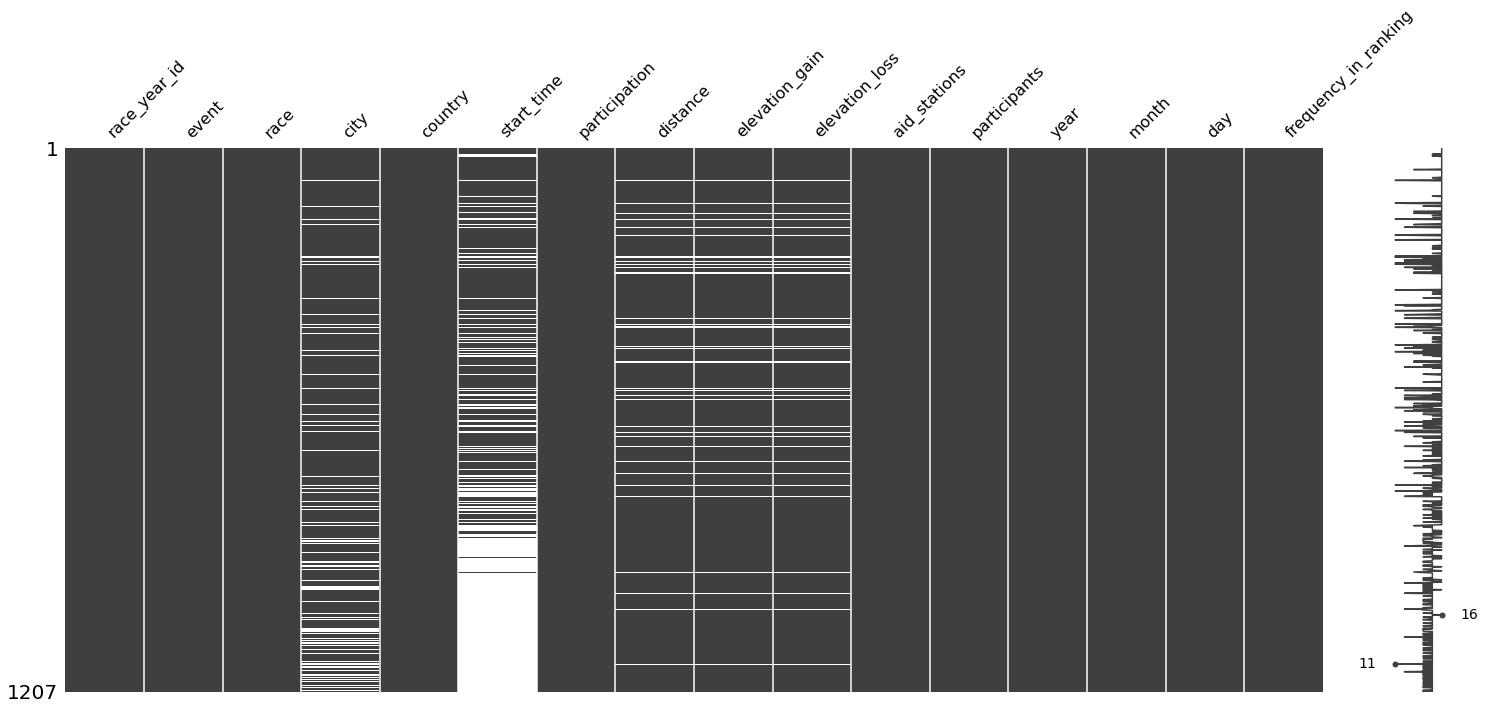

In [104]:
msno.matrix(race)

<AxesSubplot:>

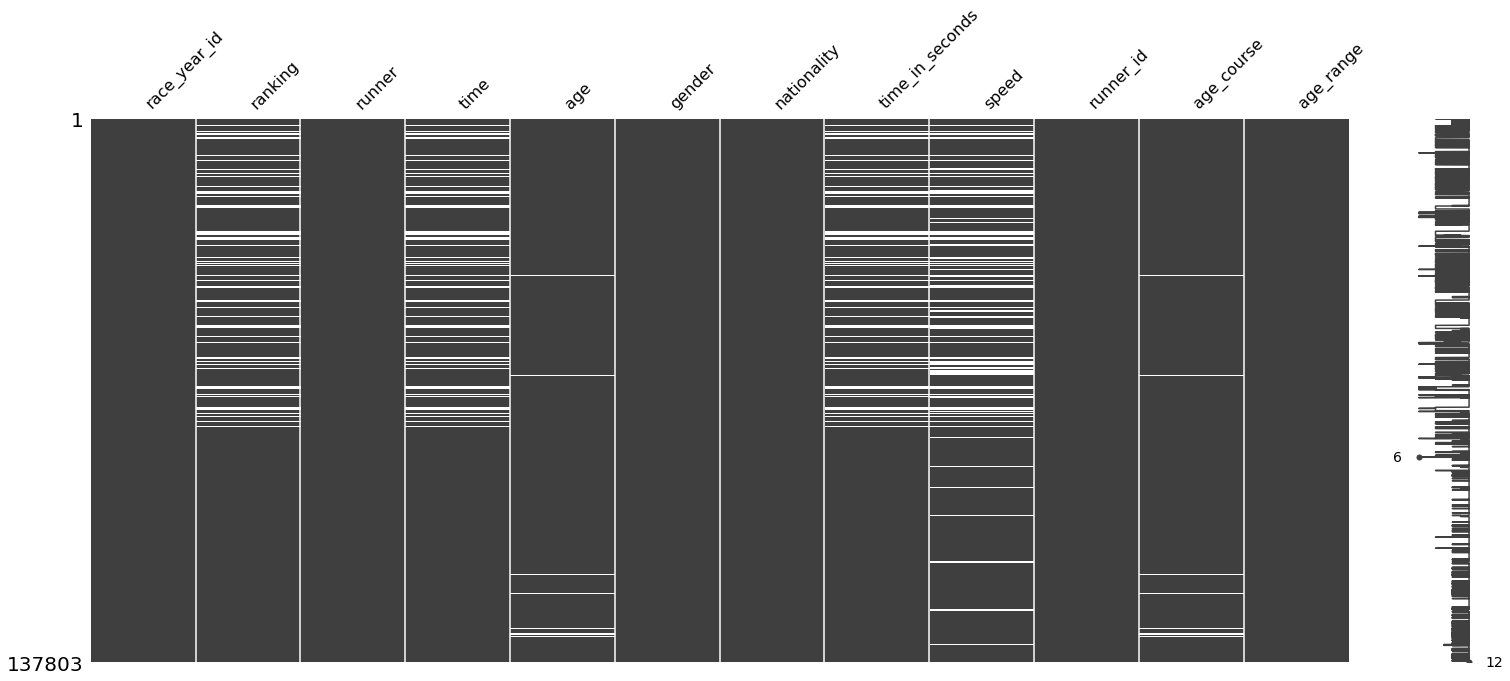

In [105]:
msno.matrix(runner)

Au vu du nombre important de NA (ranking, time), les supprimer des coureurs serait une trop grosse perte d'information. On décide donc de les garder, quitte à les recoder en -1 par la suite pour les méthodes incompatibles.

### Dropping columns

In [106]:
round(race.isna().sum() / len(race) * 100,2)

race_year_id             0.00
event                    0.00
race                     0.00
city                    14.25
country                  0.00
start_time              42.50
participation            0.00
distance                 6.13
elevation_gain           6.13
elevation_loss           6.13
aid_stations             0.00
participants             0.00
year                     0.00
month                    0.00
day                      0.00
frequency_in_ranking     0.00
dtype: float64

In [107]:
race = race.drop(columns=['city', 'start_time'])

In [108]:
runner = runner.drop(columns=['age'])

Remarque:
Les courses n'ayant pas de profil représentent 6%. Les coureurs sur ces courses représentent 5.5% de l'effectif total. On peut donc se permettre de les supprimer au vu du nombre important de données restantes.

In [109]:
id_to_delete = race[pd.isna(race.distance)].race_year_id.to_list()
runner = runner[~runner['race_year_id'].isin(id_to_delete)]

In [110]:
race = race.loc[~pd.isna(race.distance)]

<AxesSubplot:>

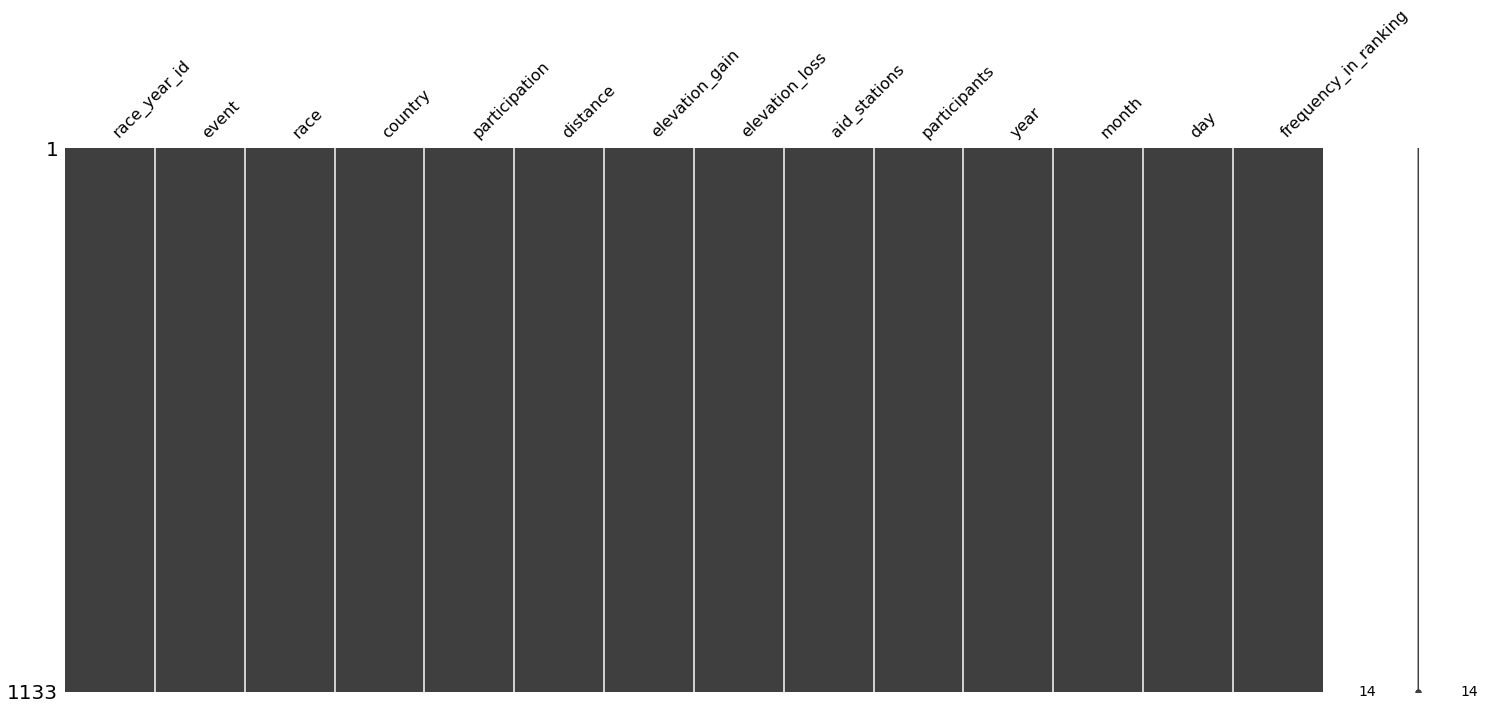

In [111]:
msno.matrix(race)

<AxesSubplot:>

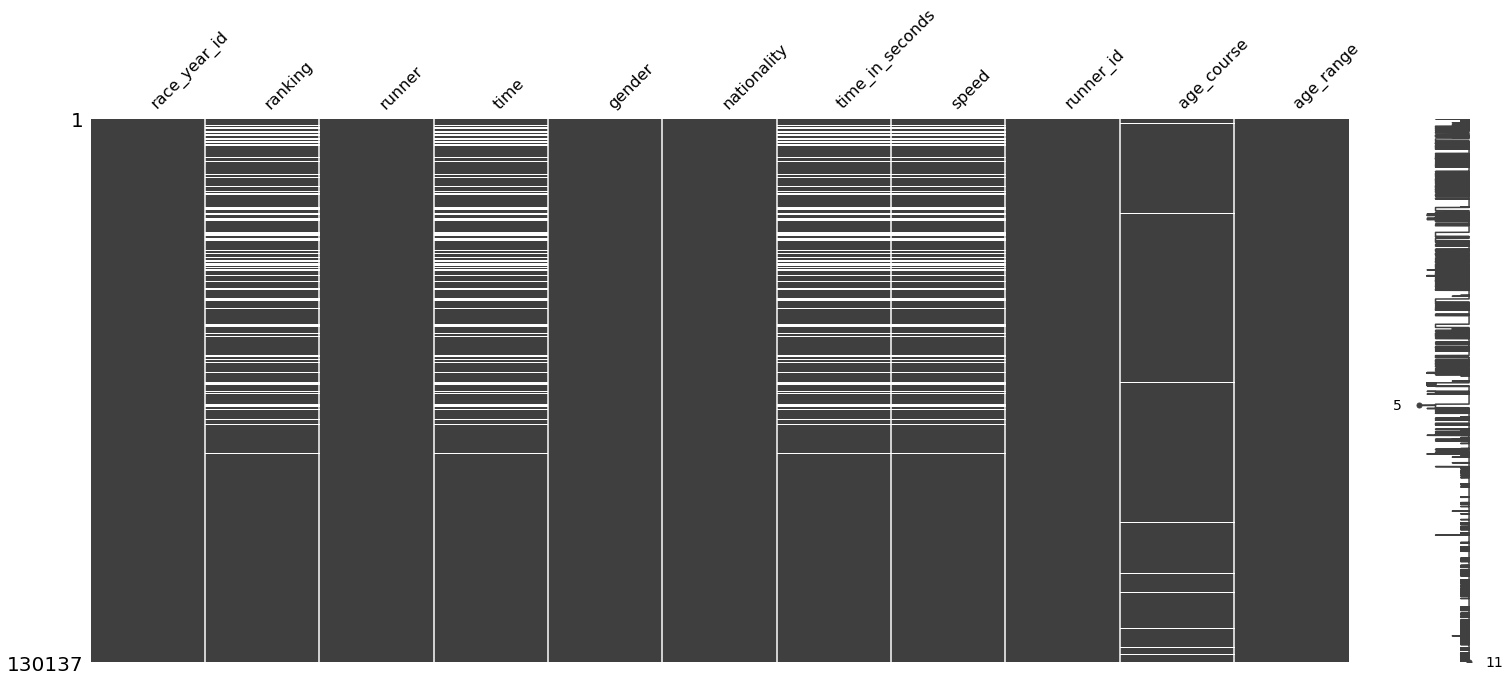

In [112]:
msno.matrix(runner)

In [113]:
from pathlib import Path  

filepath = Path('../../output/data_clean/cleaned_race_equivalent_distance.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

race.to_csv(filepath)  

In [114]:
from pathlib import Path  

filepath = Path('../../output/data_clean/cleaned_runner.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

runner.to_csv(filepath)  